This file is part of postpic.

postpic is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

postpic is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with postpic. If not, see <http://www.gnu.org/licenses/>.

Copyright Stephan Kuschel 2016-2018


First, download the example data

In [1]:
def download(url, file):
    import urllib3
    import shutil
    import os
    if os.path.isfile(file):
        return
    urllib3.disable_warnings()
    http = urllib3.PoolManager()
    print('downloading {:} ...'.format(file))
    with http.request('GET', url, preload_content=False) as r, open(file, 'wb') as out_file:
        shutil.copyfileobj(r, out_file)

# download the example data
import os
if not os.path.exists('_openPMDdata'):
    os.mkdir('_openPMDdata')
    download('https://github.com/openPMD/openPMD-example-datasets/'
        + 'raw/776ae3a96c02b20cfae56efafcbda6ca76d4c78d/example-2d.tar.gz',
            '_openPMDdata/example-2d.tar.gz')

import tarfile
tar = tarfile.open('_openPMDdata/example-2d.tar.gz')
tar.extractall('_openPMDdata')
print('done.')

downloading _openPMDdata/example-2d.tar.gz ...
done.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import postpic as pp
pp.__version__

'v0.3.1+318.ga7cb0c4'

In [3]:
pp.chooseCode('openpmd')
# open a specific dump
dr = pp.readDump('_openPMDdata/example-2d/hdf5/data00000300.h5')
print(dr)
# the dumpreader knwos all the information of the simulation
print('The simulations was running on {} spatial dimensions.'.format(dr.simdimensions()))

<OpenPMDh5reader at "_openPMDdata/example-2d/hdf5/data00000300.h5">
The simulations was running on 2 spatial dimensions.


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# if needed, postpic can be bypassed and the underlying datastructer (h5 in this case)
# can be accessed directly via keys
print(dr.keys())
dr['fields']

['fields', 'particles']


<HDF5 group "/data/300/fields" (4 members)>

# The Field data

Field data is data, which is already on a grid, examples are Electric Field, Magnetic Field, Number Density, A velocity field of the streaming particles... Such data can be accessed by the datareader directly. It is represented in postpic by a postpic.Field object, which is a numpy array holding the data plus information about the axis.


<Field "Ez" (51, 201)>


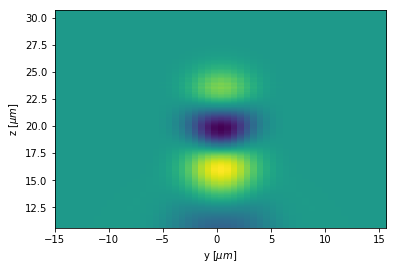

In [5]:
ez = dr.Ez()
print(ez)
fig, ax = plt.subplots()
ax.imshow(ez.T, origin='lower', extent=ez.extent*1e6)
ax.set_xlabel('y [$\mu m$]');
ax.set_ylabel('z [$\mu m$]');

# Particle data

Particle data is represented in postpic by a postpic.MultiSpecies object. It contains a number of particles and it offers a very easy to use interface to access the properties or derived quantities or even use derived quantities to create a postpic.Field object, which can finally be plotted.

In [6]:
# the multispecies Object is used to access particle data
print(dr.listSpecies())
ms = pp.MultiSpecies(dr, 'electrons')
# now, ms is representing the species "electrons"
print(ms)

['electrons', 'ions']
<MultiSpecies including all "electrons" (37728)>


In [7]:
# we can access the properties for each individual particle, like the x coordinate
x = ms('x')
print(len(x))

37728


In [8]:
# or do something more complicated such as:
pr = ms('sqrt(px**2 + py**2)')
# actually ridiculous things will work:
pr = ms('x + x**2 + (gamma**2 - 2) - sin(px/pz)')
# you can look at  for a list of predefined values
pp.particle_scalars

Ekin = gamma_m1 * mass * c**2
Ekin_MeV = Ekin / elementary_charge / 1e6
Ekin_MeV_amu = Ekin / elementary_charge / 1e6 / mass_u
Ekin_MeV_qm = Ekin / elementary_charge / 1e6 / mass_u * charge_e
Ekin_keV = Ekin / elementary_charge / 1e3
Ekin_keV_amu = Ekin / elementary_charge / 1e3 / mass_u
Ekin_keV_qm = Ekin / elementary_charge / 1e3 / mass_u * charge_e
Eruhe = mass * c**2
_np2 = (px**2 + py**2 + pz**2)/(mass * c)**2
angle_xaxis = arctan2(sqrt(py**2 + pz**2), px)
angle_xy = arctan2(py, px)
angle_xz = arctan2(pz, px)
angle_yaxis = arctan2(sqrt(pz**2 + px**2), py)
angle_yx = arctan2(px, py)
angle_yz = arctan2(pz, py)
angle_zaxis = arctan2(sqrt(px**2 + py**2), pz)
angle_zx = arctan2(px, pz)
angle_zy = arctan2(py, pz)
beta = sqrt(gamma**2 - 1) / gamma
betax = vx / c
betay = vy / c
betaz = vz / c
charge = charge
charge_e = charge / elementary_charge
gamma = _np2 / (sqrt(1 + _np2) + 1) + 1
gamma_m = gamma * mass
gamma_m1 = _np2 / (sqrt(1 + _np2) + 1)
id = id
m = mass
m_u = mass / atomic_mass
m

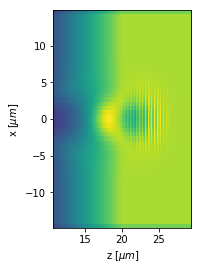

In [9]:
# we can use the particle properties to create a Field for plotting.
# Particle Shapes as in the Simulation will be included
# calculate the number density
nd = ms.createField('z', 'x', bins=[200, 50])
# note, that particle weights are included automatically
# and plot
fig, ax = plt.subplots()
ax.imshow(nd.T, origin='lower', extent=nd.extent*1e6)
ax.set_xlabel('z [$\mu m$]');
ax.set_ylabel('x [$\mu m$]');

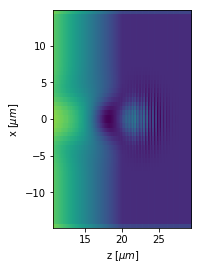

In [10]:
# create a Field object nd holding the charge density
# note, that particle weights are included automatically
qd = ms.createField('z', 'x', weights='charge', bins=[200, 50])
# and plot
fig, ax = plt.subplots()
ax.imshow(qd.T, origin='lower', extent=qd.extent*1e6)
ax.set_xlabel('z [$\mu m$]');
ax.set_ylabel('x [$\mu m$]');

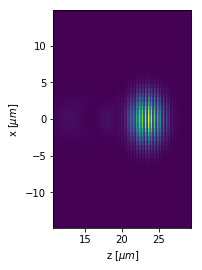

In [11]:
# average kinetic energy on grid
ekin = ms.createField('z', 'x', weights='Ekin_MeV', bins=[200, 50])
ekinavg = ekin/nd
# and plot
fig, ax = plt.subplots()
ax.imshow(ekinavg.T, origin='lower', extent=ekinavg.extent*1e6)
ax.set_xlabel('z [$\mu m$]');
ax.set_ylabel('x [$\mu m$]');

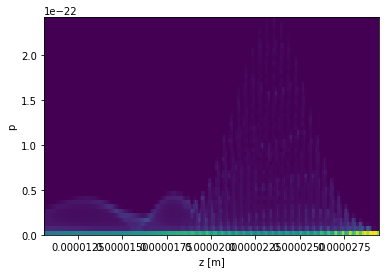

In [12]:
f = ms.createField('z', 'p', bins=[200,50])
# and plot
fig, ax = plt.subplots()
ax.imshow(f.T, origin='lower', extent=f.extent, aspect='auto')
ax.set_xlabel('z [m]');
ax.set_ylabel('p');

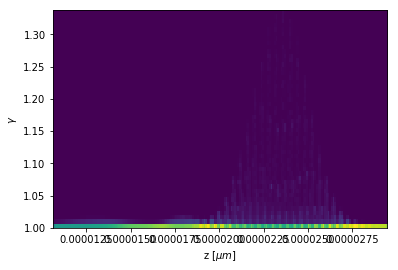

In [13]:
f = ms.createField('z', 'gamma', bins=[200,50])
# and plot
fig, ax = plt.subplots()
ax.imshow(f.T, origin='lower', extent=f.extent, aspect='auto')
ax.set_xlabel('z [$\mu m$]');
ax.set_ylabel('$\gamma$');

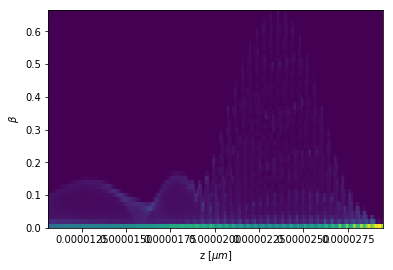

In [14]:
f = ms.createField('z', 'beta', bins=[200,50])
# and plot
fig, ax = plt.subplots()
ax.imshow(f.T, origin='lower', extent=f.extent, aspect='auto')
ax.set_xlabel('z [$\mu m$]');
ax.set_ylabel(r'$\beta$');

# The Simulationreader

The Simulationreader represents an entire simulation, i.e. a series of dumps.

In [15]:
sr = pp.readSim('_openPMDdata/example-2d/hdf5/*.h5')
print('There are {:} dumps in this simulationreader object.'.format(len(sr)))
print(sr)

There are 5 dumps in this simulationreader object.
<FileSeries at "_openPMDdata/example-2d/hdf5/*.h5">


In [16]:
for dr in sr:
    print('Simulation time of current dump t = {:.2e} s'.format(dr.time()))

Simulation time of current dump t = 3.29e-14 s
Simulation time of current dump t = 6.58e-14 s
Simulation time of current dump t = 9.87e-14 s
Simulation time of current dump t = 1.32e-13 s
Simulation time of current dump t = 1.65e-13 s


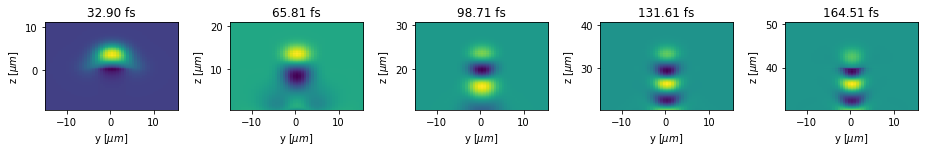

In [17]:
fig, axs = plt.subplots(1,5)
for dr, ax in zip(sr, axs):
    f = dr.Ez()
    ax.imshow(f.T, origin='lower', extent=f.extent*1e6)
    ax.set_xlabel('y [$\mu m$]');
    ax.set_ylabel('z [$\mu m$]');
    ax.set_title('{:.2f} fs'.format(dr.time()*1e15))
fig.set_size_inches(13,3)
fig.tight_layout()